# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

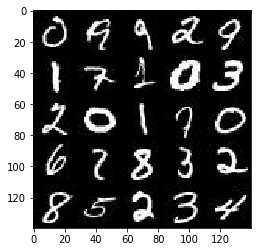

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

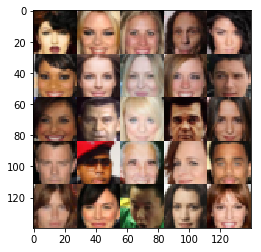

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, is_train=True):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
     
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #tf.layers.dropout(conv, keep_prob, training=is_train)
        
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
     

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
    
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7,7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
      
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
   
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
    
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
      
        out = tf.tanh(logits)
   
        return out



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_model = generator(input_z, out_channel_dim)
    
    dis_model_real, dis_logits_real = discriminator(input_real)
    
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse=True)
    
    dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_real, labels=tf.ones_like(dis_logits_real) * 0.9))
    
    dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.zeros_like(dis_logits_fake)))
    
    dis_loss = dis_loss_real + dis_loss_fake
    
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.ones_like(dis_logits_fake)))
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
    
    #with tf.control_dependencies(update_ops):
        
    t_vars = tf.trainable_variables()

    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
    out_channel_dim = 3 if data_image_mode == "RGB" else 1
    
    input_real, input_z, l_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    
    losses = []
    
    iteration = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                iteration += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if iteration % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    losses.append((train_loss_d, train_loss_g))
                    
                    print("Epoch {}/{}, iteration {}:".format(epoch_i + 1, epochs, iteration),
                          "Discriminator Loss: {:.4f},".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if iteration % 100 == 0:
                     show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')
        
    
    
    return losses
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2, iteration 10: Discriminator Loss: 0.6457, Generator Loss: 15.3278
Epoch 1/2, iteration 20: Discriminator Loss: 0.5794, Generator Loss: 4.5424
Epoch 1/2, iteration 30: Discriminator Loss: 2.0816, Generator Loss: 0.7572
Epoch 1/2, iteration 40: Discriminator Loss: 0.8717, Generator Loss: 1.7749
Epoch 1/2, iteration 50: Discriminator Loss: 1.3327, Generator Loss: 0.8574
Epoch 1/2, iteration 60: Discriminator Loss: 0.8242, Generator Loss: 1.5638
Epoch 1/2, iteration 70: Discriminator Loss: 1.1509, Generator Loss: 0.8993
Epoch 1/2, iteration 80: Discriminator Loss: 2.6909, Generator Loss: 4.4313
Epoch 1/2, iteration 90: Discriminator Loss: 2.0963, Generator Loss: 3.0106
Epoch 1/2, iteration 100: Discriminator Loss: 1.0715, Generator Loss: 1.0070


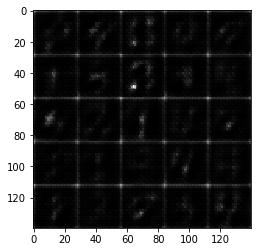

Epoch 1/2, iteration 110: Discriminator Loss: 1.1719, Generator Loss: 0.8055
Epoch 1/2, iteration 120: Discriminator Loss: 1.3028, Generator Loss: 0.6836
Epoch 1/2, iteration 130: Discriminator Loss: 1.3387, Generator Loss: 1.4962
Epoch 1/2, iteration 140: Discriminator Loss: 1.3841, Generator Loss: 0.6038
Epoch 1/2, iteration 150: Discriminator Loss: 1.2819, Generator Loss: 1.5691
Epoch 1/2, iteration 160: Discriminator Loss: 1.2649, Generator Loss: 1.5449
Epoch 1/2, iteration 170: Discriminator Loss: 1.3734, Generator Loss: 2.6260
Epoch 1/2, iteration 180: Discriminator Loss: 1.2329, Generator Loss: 1.2299
Epoch 1/2, iteration 190: Discriminator Loss: 1.0523, Generator Loss: 1.2303
Epoch 1/2, iteration 200: Discriminator Loss: 1.3878, Generator Loss: 0.6807


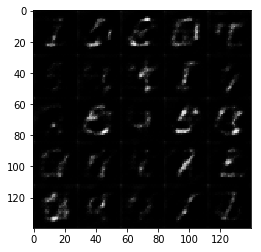

Epoch 1/2, iteration 210: Discriminator Loss: 1.5514, Generator Loss: 0.6251
Epoch 1/2, iteration 220: Discriminator Loss: 1.4150, Generator Loss: 0.5912
Epoch 1/2, iteration 230: Discriminator Loss: 1.1855, Generator Loss: 1.6316
Epoch 1/2, iteration 240: Discriminator Loss: 1.3043, Generator Loss: 1.9107
Epoch 1/2, iteration 250: Discriminator Loss: 1.1797, Generator Loss: 1.8329
Epoch 1/2, iteration 260: Discriminator Loss: 1.0684, Generator Loss: 0.9139
Epoch 1/2, iteration 270: Discriminator Loss: 1.1129, Generator Loss: 1.1139
Epoch 1/2, iteration 280: Discriminator Loss: 1.3830, Generator Loss: 0.5752
Epoch 1/2, iteration 290: Discriminator Loss: 1.4028, Generator Loss: 1.8816
Epoch 1/2, iteration 300: Discriminator Loss: 1.1891, Generator Loss: 0.7997


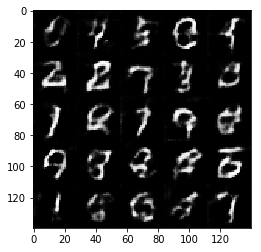

Epoch 1/2, iteration 310: Discriminator Loss: 1.0949, Generator Loss: 0.9467
Epoch 1/2, iteration 320: Discriminator Loss: 1.1217, Generator Loss: 1.0902
Epoch 1/2, iteration 330: Discriminator Loss: 1.1823, Generator Loss: 0.8373
Epoch 1/2, iteration 340: Discriminator Loss: 1.4306, Generator Loss: 0.5224
Epoch 1/2, iteration 350: Discriminator Loss: 1.1130, Generator Loss: 1.3847
Epoch 1/2, iteration 360: Discriminator Loss: 1.3386, Generator Loss: 1.7336
Epoch 1/2, iteration 370: Discriminator Loss: 1.2834, Generator Loss: 0.6531
Epoch 1/2, iteration 380: Discriminator Loss: 1.1414, Generator Loss: 0.9170
Epoch 1/2, iteration 390: Discriminator Loss: 1.1625, Generator Loss: 0.9302
Epoch 1/2, iteration 400: Discriminator Loss: 1.1784, Generator Loss: 1.3903


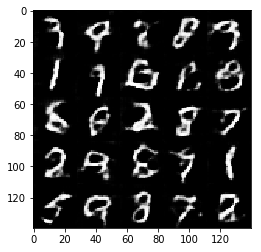

Epoch 1/2, iteration 410: Discriminator Loss: 1.1450, Generator Loss: 0.9636
Epoch 1/2, iteration 420: Discriminator Loss: 1.1947, Generator Loss: 0.8433
Epoch 1/2, iteration 430: Discriminator Loss: 1.1882, Generator Loss: 1.2171
Epoch 1/2, iteration 440: Discriminator Loss: 1.3392, Generator Loss: 0.5933
Epoch 1/2, iteration 450: Discriminator Loss: 1.2021, Generator Loss: 0.7984
Epoch 1/2, iteration 460: Discriminator Loss: 1.2747, Generator Loss: 0.9546
Epoch 2/2, iteration 470: Discriminator Loss: 1.1519, Generator Loss: 0.9227
Epoch 2/2, iteration 480: Discriminator Loss: 1.2723, Generator Loss: 0.9367
Epoch 2/2, iteration 490: Discriminator Loss: 1.6514, Generator Loss: 0.4030
Epoch 2/2, iteration 500: Discriminator Loss: 1.1711, Generator Loss: 0.9413


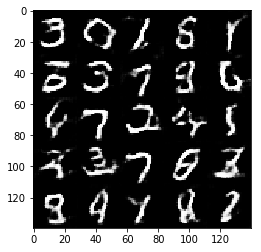

Epoch 2/2, iteration 510: Discriminator Loss: 1.1783, Generator Loss: 0.8482
Epoch 2/2, iteration 520: Discriminator Loss: 1.2963, Generator Loss: 1.5804
Epoch 2/2, iteration 530: Discriminator Loss: 1.5315, Generator Loss: 0.4480
Epoch 2/2, iteration 540: Discriminator Loss: 1.1079, Generator Loss: 1.0022
Epoch 2/2, iteration 550: Discriminator Loss: 1.0592, Generator Loss: 1.2389
Epoch 2/2, iteration 560: Discriminator Loss: 1.2459, Generator Loss: 0.7401
Epoch 2/2, iteration 570: Discriminator Loss: 1.3169, Generator Loss: 0.6686
Epoch 2/2, iteration 580: Discriminator Loss: 1.1255, Generator Loss: 0.9561
Epoch 2/2, iteration 590: Discriminator Loss: 1.4014, Generator Loss: 0.5633
Epoch 2/2, iteration 600: Discriminator Loss: 1.0967, Generator Loss: 1.0052


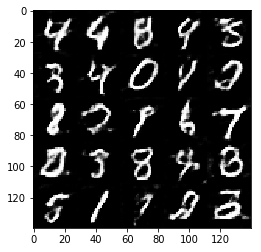

Epoch 2/2, iteration 610: Discriminator Loss: 1.1261, Generator Loss: 1.6298
Epoch 2/2, iteration 620: Discriminator Loss: 1.1653, Generator Loss: 0.9436
Epoch 2/2, iteration 630: Discriminator Loss: 1.2467, Generator Loss: 1.5171
Epoch 2/2, iteration 640: Discriminator Loss: 2.1926, Generator Loss: 2.8809
Epoch 2/2, iteration 650: Discriminator Loss: 1.2284, Generator Loss: 0.9760
Epoch 2/2, iteration 660: Discriminator Loss: 1.2146, Generator Loss: 0.9033
Epoch 2/2, iteration 670: Discriminator Loss: 1.2607, Generator Loss: 0.6244
Epoch 2/2, iteration 680: Discriminator Loss: 1.1297, Generator Loss: 0.8658
Epoch 2/2, iteration 690: Discriminator Loss: 1.2295, Generator Loss: 0.7126
Epoch 2/2, iteration 700: Discriminator Loss: 1.1085, Generator Loss: 1.2706


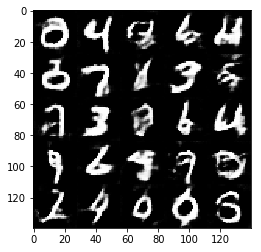

Epoch 2/2, iteration 710: Discriminator Loss: 1.5924, Generator Loss: 2.4122
Epoch 2/2, iteration 720: Discriminator Loss: 1.1956, Generator Loss: 0.8437
Epoch 2/2, iteration 730: Discriminator Loss: 1.0903, Generator Loss: 1.3359
Epoch 2/2, iteration 740: Discriminator Loss: 1.3088, Generator Loss: 0.5763
Epoch 2/2, iteration 750: Discriminator Loss: 0.9977, Generator Loss: 1.0801
Epoch 2/2, iteration 760: Discriminator Loss: 1.0609, Generator Loss: 1.1489
Epoch 2/2, iteration 770: Discriminator Loss: 1.0560, Generator Loss: 1.1271
Epoch 2/2, iteration 780: Discriminator Loss: 1.2052, Generator Loss: 0.7076
Epoch 2/2, iteration 790: Discriminator Loss: 1.1424, Generator Loss: 0.7520
Epoch 2/2, iteration 800: Discriminator Loss: 1.0609, Generator Loss: 1.2467


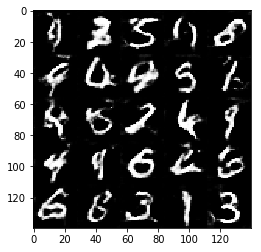

Epoch 2/2, iteration 810: Discriminator Loss: 1.0298, Generator Loss: 1.1144
Epoch 2/2, iteration 820: Discriminator Loss: 2.3484, Generator Loss: 3.0757
Epoch 2/2, iteration 830: Discriminator Loss: 1.2028, Generator Loss: 1.0954
Epoch 2/2, iteration 840: Discriminator Loss: 1.1786, Generator Loss: 1.0015
Epoch 2/2, iteration 850: Discriminator Loss: 1.1970, Generator Loss: 1.2462
Epoch 2/2, iteration 860: Discriminator Loss: 1.1957, Generator Loss: 0.7680
Epoch 2/2, iteration 870: Discriminator Loss: 1.1627, Generator Loss: 0.9649
Epoch 2/2, iteration 880: Discriminator Loss: 1.1801, Generator Loss: 0.8124
Epoch 2/2, iteration 890: Discriminator Loss: 1.1402, Generator Loss: 0.8052
Epoch 2/2, iteration 900: Discriminator Loss: 1.0598, Generator Loss: 1.3345


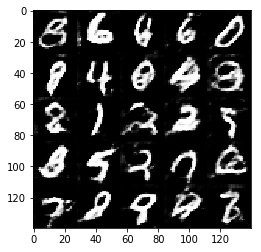

Epoch 2/2, iteration 910: Discriminator Loss: 1.0555, Generator Loss: 1.1108
Epoch 2/2, iteration 920: Discriminator Loss: 1.0798, Generator Loss: 0.8593
Epoch 2/2, iteration 930: Discriminator Loss: 1.1864, Generator Loss: 2.1058


ValueError: Parent directory of ./checkpoints/generator.ckpt doesn't exist, can't save.

In [14]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1, iteration 10: Discriminator Loss: 2.1757, Generator Loss: 0.3354
Epoch 1/1, iteration 20: Discriminator Loss: 1.4279, Generator Loss: 0.6797
Epoch 1/1, iteration 30: Discriminator Loss: 0.9797, Generator Loss: 1.1144
Epoch 1/1, iteration 40: Discriminator Loss: 0.7548, Generator Loss: 1.5351
Epoch 1/1, iteration 50: Discriminator Loss: 0.6892, Generator Loss: 1.7631
Epoch 1/1, iteration 60: Discriminator Loss: 0.8490, Generator Loss: 1.8990
Epoch 1/1, iteration 70: Discriminator Loss: 0.6748, Generator Loss: 2.7876
Epoch 1/1, iteration 80: Discriminator Loss: 0.8396, Generator Loss: 1.2907
Epoch 1/1, iteration 90: Discriminator Loss: 0.8623, Generator Loss: 1.4966
Epoch 1/1, iteration 100: Discriminator Loss: 1.2986, Generator Loss: 1.0300


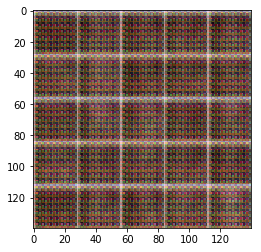

Epoch 1/1, iteration 110: Discriminator Loss: 1.0859, Generator Loss: 2.1785
Epoch 1/1, iteration 120: Discriminator Loss: 0.9969, Generator Loss: 1.0770
Epoch 1/1, iteration 130: Discriminator Loss: 0.8684, Generator Loss: 1.2394
Epoch 1/1, iteration 140: Discriminator Loss: 0.9460, Generator Loss: 1.7414
Epoch 1/1, iteration 150: Discriminator Loss: 1.0871, Generator Loss: 2.2223
Epoch 1/1, iteration 160: Discriminator Loss: 1.3532, Generator Loss: 0.6843
Epoch 1/1, iteration 170: Discriminator Loss: 1.2315, Generator Loss: 0.8865
Epoch 1/1, iteration 180: Discriminator Loss: 0.9801, Generator Loss: 1.5142
Epoch 1/1, iteration 190: Discriminator Loss: 0.9691, Generator Loss: 1.2461
Epoch 1/1, iteration 200: Discriminator Loss: 1.0504, Generator Loss: 1.3290


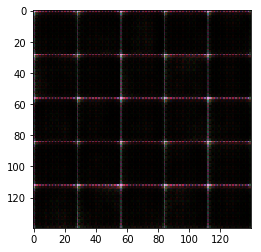

Epoch 1/1, iteration 210: Discriminator Loss: 1.1989, Generator Loss: 0.9940
Epoch 1/1, iteration 220: Discriminator Loss: 1.2027, Generator Loss: 1.1444
Epoch 1/1, iteration 230: Discriminator Loss: 1.4944, Generator Loss: 0.5183
Epoch 1/1, iteration 240: Discriminator Loss: 1.4321, Generator Loss: 1.5409
Epoch 1/1, iteration 250: Discriminator Loss: 1.1562, Generator Loss: 1.0317
Epoch 1/1, iteration 260: Discriminator Loss: 1.0791, Generator Loss: 1.2172
Epoch 1/1, iteration 270: Discriminator Loss: 1.2306, Generator Loss: 0.8239
Epoch 1/1, iteration 280: Discriminator Loss: 0.9823, Generator Loss: 1.2442
Epoch 1/1, iteration 290: Discriminator Loss: 1.1362, Generator Loss: 0.7779
Epoch 1/1, iteration 300: Discriminator Loss: 1.2690, Generator Loss: 1.9113


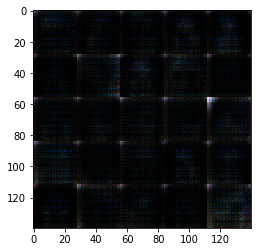

Epoch 1/1, iteration 310: Discriminator Loss: 1.1710, Generator Loss: 1.0579
Epoch 1/1, iteration 320: Discriminator Loss: 1.3379, Generator Loss: 0.7740
Epoch 1/1, iteration 330: Discriminator Loss: 1.2864, Generator Loss: 0.6695
Epoch 1/1, iteration 340: Discriminator Loss: 1.2055, Generator Loss: 1.6833
Epoch 1/1, iteration 350: Discriminator Loss: 1.2788, Generator Loss: 0.8492
Epoch 1/1, iteration 360: Discriminator Loss: 0.9961, Generator Loss: 1.2288
Epoch 1/1, iteration 370: Discriminator Loss: 1.0921, Generator Loss: 0.9458
Epoch 1/1, iteration 380: Discriminator Loss: 0.9509, Generator Loss: 1.1370
Epoch 1/1, iteration 390: Discriminator Loss: 1.1498, Generator Loss: 1.2435
Epoch 1/1, iteration 400: Discriminator Loss: 1.6496, Generator Loss: 0.6303


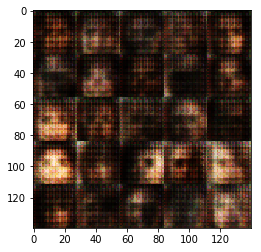

Epoch 1/1, iteration 410: Discriminator Loss: 1.4203, Generator Loss: 0.8371
Epoch 1/1, iteration 420: Discriminator Loss: 1.0674, Generator Loss: 1.4771
Epoch 1/1, iteration 430: Discriminator Loss: 1.4017, Generator Loss: 0.7047
Epoch 1/1, iteration 440: Discriminator Loss: 1.0461, Generator Loss: 1.1175
Epoch 1/1, iteration 450: Discriminator Loss: 1.5586, Generator Loss: 0.6748
Epoch 1/1, iteration 460: Discriminator Loss: 1.4704, Generator Loss: 1.4973
Epoch 1/1, iteration 470: Discriminator Loss: 1.3444, Generator Loss: 0.8456
Epoch 1/1, iteration 480: Discriminator Loss: 1.2407, Generator Loss: 0.9240
Epoch 1/1, iteration 490: Discriminator Loss: 1.1274, Generator Loss: 1.1987
Epoch 1/1, iteration 500: Discriminator Loss: 1.3858, Generator Loss: 0.9028


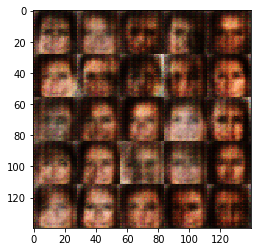

Epoch 1/1, iteration 510: Discriminator Loss: 1.8850, Generator Loss: 0.6167
Epoch 1/1, iteration 520: Discriminator Loss: 1.3506, Generator Loss: 0.9405
Epoch 1/1, iteration 530: Discriminator Loss: 1.3404, Generator Loss: 1.0453
Epoch 1/1, iteration 540: Discriminator Loss: 1.1929, Generator Loss: 0.9242
Epoch 1/1, iteration 550: Discriminator Loss: 1.4929, Generator Loss: 0.8013
Epoch 1/1, iteration 560: Discriminator Loss: 1.2201, Generator Loss: 0.9845
Epoch 1/1, iteration 570: Discriminator Loss: 1.2317, Generator Loss: 0.9755
Epoch 1/1, iteration 580: Discriminator Loss: 1.3494, Generator Loss: 0.8061
Epoch 1/1, iteration 590: Discriminator Loss: 1.2867, Generator Loss: 0.9490
Epoch 1/1, iteration 600: Discriminator Loss: 1.2956, Generator Loss: 0.9473


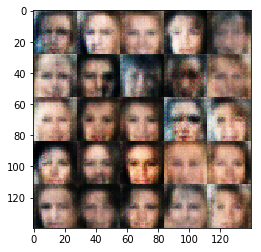

Epoch 1/1, iteration 610: Discriminator Loss: 1.2537, Generator Loss: 0.9781
Epoch 1/1, iteration 620: Discriminator Loss: 1.2322, Generator Loss: 0.8969
Epoch 1/1, iteration 630: Discriminator Loss: 1.3845, Generator Loss: 0.9507
Epoch 1/1, iteration 640: Discriminator Loss: 1.3145, Generator Loss: 0.8732
Epoch 1/1, iteration 650: Discriminator Loss: 1.3690, Generator Loss: 1.1478
Epoch 1/1, iteration 660: Discriminator Loss: 1.2736, Generator Loss: 0.9248
Epoch 1/1, iteration 670: Discriminator Loss: 1.2381, Generator Loss: 0.8831
Epoch 1/1, iteration 680: Discriminator Loss: 1.1644, Generator Loss: 0.9240
Epoch 1/1, iteration 690: Discriminator Loss: 1.2077, Generator Loss: 0.9265
Epoch 1/1, iteration 700: Discriminator Loss: 1.3014, Generator Loss: 0.9350


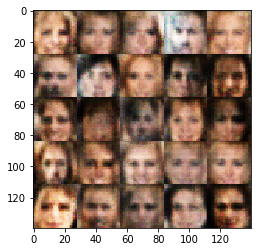

Epoch 1/1, iteration 710: Discriminator Loss: 1.3065, Generator Loss: 0.8512
Epoch 1/1, iteration 720: Discriminator Loss: 1.2458, Generator Loss: 0.8205
Epoch 1/1, iteration 730: Discriminator Loss: 1.3987, Generator Loss: 0.8264
Epoch 1/1, iteration 740: Discriminator Loss: 1.2406, Generator Loss: 0.8426
Epoch 1/1, iteration 750: Discriminator Loss: 1.3119, Generator Loss: 1.0886
Epoch 1/1, iteration 760: Discriminator Loss: 1.2707, Generator Loss: 0.9176
Epoch 1/1, iteration 770: Discriminator Loss: 1.3912, Generator Loss: 0.9364
Epoch 1/1, iteration 780: Discriminator Loss: 1.2599, Generator Loss: 0.9006
Epoch 1/1, iteration 790: Discriminator Loss: 1.3380, Generator Loss: 0.9047
Epoch 1/1, iteration 800: Discriminator Loss: 1.2730, Generator Loss: 0.8809


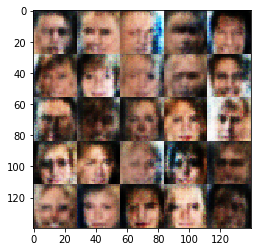

Epoch 1/1, iteration 810: Discriminator Loss: 1.3725, Generator Loss: 0.9503
Epoch 1/1, iteration 820: Discriminator Loss: 1.4137, Generator Loss: 0.7136
Epoch 1/1, iteration 830: Discriminator Loss: 1.3316, Generator Loss: 0.8027
Epoch 1/1, iteration 840: Discriminator Loss: 1.3513, Generator Loss: 0.7915
Epoch 1/1, iteration 850: Discriminator Loss: 1.2453, Generator Loss: 0.9545
Epoch 1/1, iteration 860: Discriminator Loss: 1.4184, Generator Loss: 1.4216
Epoch 1/1, iteration 870: Discriminator Loss: 1.2068, Generator Loss: 0.8696
Epoch 1/1, iteration 880: Discriminator Loss: 1.3984, Generator Loss: 0.5989
Epoch 1/1, iteration 890: Discriminator Loss: 1.4662, Generator Loss: 0.7916
Epoch 1/1, iteration 900: Discriminator Loss: 1.3712, Generator Loss: 0.8489


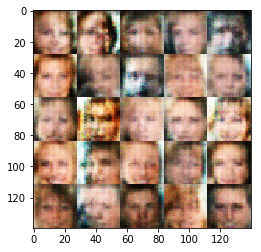

Epoch 1/1, iteration 910: Discriminator Loss: 1.3811, Generator Loss: 0.9274
Epoch 1/1, iteration 920: Discriminator Loss: 1.3480, Generator Loss: 0.9151
Epoch 1/1, iteration 930: Discriminator Loss: 1.2242, Generator Loss: 1.0933
Epoch 1/1, iteration 940: Discriminator Loss: 1.2624, Generator Loss: 1.0818
Epoch 1/1, iteration 950: Discriminator Loss: 1.2288, Generator Loss: 0.8156
Epoch 1/1, iteration 960: Discriminator Loss: 1.2838, Generator Loss: 0.9894
Epoch 1/1, iteration 970: Discriminator Loss: 1.1744, Generator Loss: 1.0113
Epoch 1/1, iteration 980: Discriminator Loss: 1.1672, Generator Loss: 1.0264
Epoch 1/1, iteration 990: Discriminator Loss: 1.4828, Generator Loss: 0.6426
Epoch 1/1, iteration 1000: Discriminator Loss: 1.0789, Generator Loss: 1.0974


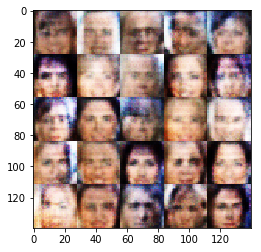

Epoch 1/1, iteration 1010: Discriminator Loss: 1.2247, Generator Loss: 0.9193
Epoch 1/1, iteration 1020: Discriminator Loss: 1.2387, Generator Loss: 0.8835
Epoch 1/1, iteration 1030: Discriminator Loss: 1.3230, Generator Loss: 1.1472
Epoch 1/1, iteration 1040: Discriminator Loss: 1.3316, Generator Loss: 0.9340
Epoch 1/1, iteration 1050: Discriminator Loss: 1.3198, Generator Loss: 0.8113
Epoch 1/1, iteration 1060: Discriminator Loss: 1.2073, Generator Loss: 0.9370
Epoch 1/1, iteration 1070: Discriminator Loss: 1.3342, Generator Loss: 0.7700
Epoch 1/1, iteration 1080: Discriminator Loss: 1.1588, Generator Loss: 0.8876
Epoch 1/1, iteration 1090: Discriminator Loss: 1.2055, Generator Loss: 0.9503
Epoch 1/1, iteration 1100: Discriminator Loss: 1.3112, Generator Loss: 0.8064


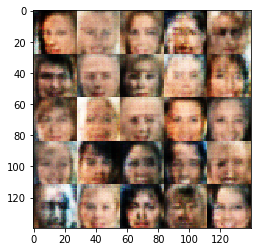

Epoch 1/1, iteration 1110: Discriminator Loss: 1.3534, Generator Loss: 0.9806
Epoch 1/1, iteration 1120: Discriminator Loss: 1.1931, Generator Loss: 0.9942
Epoch 1/1, iteration 1130: Discriminator Loss: 1.3169, Generator Loss: 0.9202
Epoch 1/1, iteration 1140: Discriminator Loss: 1.2405, Generator Loss: 1.0006
Epoch 1/1, iteration 1150: Discriminator Loss: 1.1884, Generator Loss: 0.9004
Epoch 1/1, iteration 1160: Discriminator Loss: 1.3435, Generator Loss: 0.7789
Epoch 1/1, iteration 1170: Discriminator Loss: 1.2254, Generator Loss: 0.9676
Epoch 1/1, iteration 1180: Discriminator Loss: 1.3122, Generator Loss: 0.6666
Epoch 1/1, iteration 1190: Discriminator Loss: 1.3288, Generator Loss: 0.9360
Epoch 1/1, iteration 1200: Discriminator Loss: 1.4029, Generator Loss: 0.7582


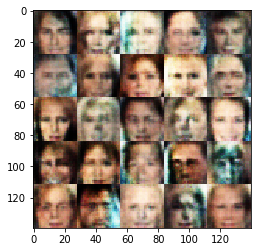

Epoch 1/1, iteration 1210: Discriminator Loss: 1.5109, Generator Loss: 0.8098
Epoch 1/1, iteration 1220: Discriminator Loss: 1.3019, Generator Loss: 0.9539
Epoch 1/1, iteration 1230: Discriminator Loss: 1.2992, Generator Loss: 0.7468
Epoch 1/1, iteration 1240: Discriminator Loss: 1.3471, Generator Loss: 0.7276
Epoch 1/1, iteration 1250: Discriminator Loss: 1.1812, Generator Loss: 1.1009
Epoch 1/1, iteration 1260: Discriminator Loss: 1.2775, Generator Loss: 0.9126
Epoch 1/1, iteration 1270: Discriminator Loss: 1.2842, Generator Loss: 0.9188
Epoch 1/1, iteration 1280: Discriminator Loss: 1.4558, Generator Loss: 0.7418
Epoch 1/1, iteration 1290: Discriminator Loss: 1.2243, Generator Loss: 0.8982
Epoch 1/1, iteration 1300: Discriminator Loss: 1.2830, Generator Loss: 0.7439


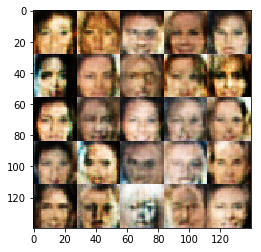

Epoch 1/1, iteration 1310: Discriminator Loss: 1.2157, Generator Loss: 0.9253
Epoch 1/1, iteration 1320: Discriminator Loss: 1.2380, Generator Loss: 0.8916
Epoch 1/1, iteration 1330: Discriminator Loss: 1.2367, Generator Loss: 0.7876
Epoch 1/1, iteration 1340: Discriminator Loss: 1.3116, Generator Loss: 0.8152
Epoch 1/1, iteration 1350: Discriminator Loss: 1.2717, Generator Loss: 0.9466
Epoch 1/1, iteration 1360: Discriminator Loss: 1.1668, Generator Loss: 1.0054
Epoch 1/1, iteration 1370: Discriminator Loss: 1.1736, Generator Loss: 1.2062
Epoch 1/1, iteration 1380: Discriminator Loss: 1.4362, Generator Loss: 0.6140
Epoch 1/1, iteration 1390: Discriminator Loss: 1.1460, Generator Loss: 0.9238
Epoch 1/1, iteration 1400: Discriminator Loss: 1.2911, Generator Loss: 0.9605


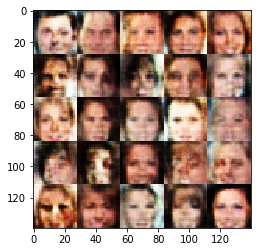

Epoch 1/1, iteration 1410: Discriminator Loss: 1.2538, Generator Loss: 0.7484
Epoch 1/1, iteration 1420: Discriminator Loss: 1.3781, Generator Loss: 0.8699
Epoch 1/1, iteration 1430: Discriminator Loss: 1.3450, Generator Loss: 0.8073
Epoch 1/1, iteration 1440: Discriminator Loss: 1.3451, Generator Loss: 0.7345
Epoch 1/1, iteration 1450: Discriminator Loss: 1.2022, Generator Loss: 0.9564
Epoch 1/1, iteration 1460: Discriminator Loss: 1.1689, Generator Loss: 0.9469
Epoch 1/1, iteration 1470: Discriminator Loss: 1.3253, Generator Loss: 0.8224
Epoch 1/1, iteration 1480: Discriminator Loss: 1.5037, Generator Loss: 0.8144
Epoch 1/1, iteration 1490: Discriminator Loss: 1.4029, Generator Loss: 1.0855
Epoch 1/1, iteration 1500: Discriminator Loss: 1.1887, Generator Loss: 1.0244


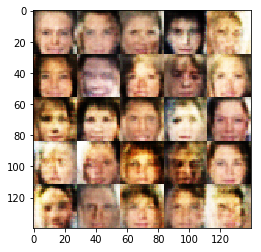

Epoch 1/1, iteration 1510: Discriminator Loss: 1.1446, Generator Loss: 0.8878
Epoch 1/1, iteration 1520: Discriminator Loss: 1.2587, Generator Loss: 0.9022
Epoch 1/1, iteration 1530: Discriminator Loss: 1.2775, Generator Loss: 0.8980
Epoch 1/1, iteration 1540: Discriminator Loss: 1.3573, Generator Loss: 0.7773
Epoch 1/1, iteration 1550: Discriminator Loss: 1.2305, Generator Loss: 0.8464
Epoch 1/1, iteration 1560: Discriminator Loss: 1.2496, Generator Loss: 0.8946
Epoch 1/1, iteration 1570: Discriminator Loss: 1.2456, Generator Loss: 0.9319
Epoch 1/1, iteration 1580: Discriminator Loss: 1.2370, Generator Loss: 0.7552
Epoch 1/1, iteration 1590: Discriminator Loss: 1.3608, Generator Loss: 0.7448
Epoch 1/1, iteration 1600: Discriminator Loss: 1.3345, Generator Loss: 0.8288


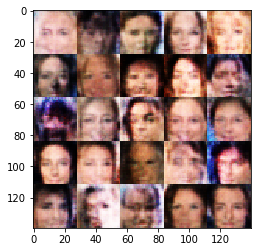

Epoch 1/1, iteration 1610: Discriminator Loss: 1.2536, Generator Loss: 0.9410
Epoch 1/1, iteration 1620: Discriminator Loss: 1.4109, Generator Loss: 0.6602
Epoch 1/1, iteration 1630: Discriminator Loss: 1.3881, Generator Loss: 0.9836
Epoch 1/1, iteration 1640: Discriminator Loss: 1.3255, Generator Loss: 0.8123
Epoch 1/1, iteration 1650: Discriminator Loss: 1.3655, Generator Loss: 0.8171
Epoch 1/1, iteration 1660: Discriminator Loss: 1.3024, Generator Loss: 0.8364
Epoch 1/1, iteration 1670: Discriminator Loss: 1.0631, Generator Loss: 1.3049
Epoch 1/1, iteration 1680: Discriminator Loss: 1.2517, Generator Loss: 0.9894
Epoch 1/1, iteration 1690: Discriminator Loss: 1.2010, Generator Loss: 0.9234
Epoch 1/1, iteration 1700: Discriminator Loss: 1.1606, Generator Loss: 0.9309


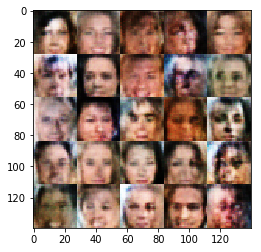

Epoch 1/1, iteration 1710: Discriminator Loss: 1.2514, Generator Loss: 0.7301
Epoch 1/1, iteration 1720: Discriminator Loss: 1.2314, Generator Loss: 0.8603
Epoch 1/1, iteration 1730: Discriminator Loss: 1.2933, Generator Loss: 0.8133
Epoch 1/1, iteration 1740: Discriminator Loss: 1.3242, Generator Loss: 0.9052
Epoch 1/1, iteration 1750: Discriminator Loss: 1.3951, Generator Loss: 0.6694
Epoch 1/1, iteration 1760: Discriminator Loss: 1.2802, Generator Loss: 0.8954
Epoch 1/1, iteration 1770: Discriminator Loss: 1.0991, Generator Loss: 0.9434
Epoch 1/1, iteration 1780: Discriminator Loss: 1.1976, Generator Loss: 0.9680
Epoch 1/1, iteration 1790: Discriminator Loss: 1.2709, Generator Loss: 0.8464
Epoch 1/1, iteration 1800: Discriminator Loss: 1.2767, Generator Loss: 0.9150


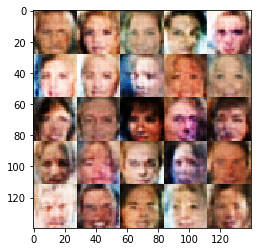

Epoch 1/1, iteration 1810: Discriminator Loss: 1.3618, Generator Loss: 0.8879
Epoch 1/1, iteration 1820: Discriminator Loss: 1.0530, Generator Loss: 1.1352
Epoch 1/1, iteration 1830: Discriminator Loss: 1.3011, Generator Loss: 0.7547
Epoch 1/1, iteration 1840: Discriminator Loss: 1.2059, Generator Loss: 0.8983
Epoch 1/1, iteration 1850: Discriminator Loss: 1.5172, Generator Loss: 0.6665
Epoch 1/1, iteration 1860: Discriminator Loss: 1.2913, Generator Loss: 0.9782
Epoch 1/1, iteration 1870: Discriminator Loss: 1.1928, Generator Loss: 0.8923
Epoch 1/1, iteration 1880: Discriminator Loss: 1.2380, Generator Loss: 0.8983
Epoch 1/1, iteration 1890: Discriminator Loss: 1.3051, Generator Loss: 0.8814
Epoch 1/1, iteration 1900: Discriminator Loss: 1.1196, Generator Loss: 1.2420


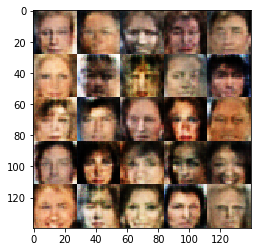

Epoch 1/1, iteration 1910: Discriminator Loss: 1.2061, Generator Loss: 0.9367
Epoch 1/1, iteration 1920: Discriminator Loss: 1.2695, Generator Loss: 1.0475
Epoch 1/1, iteration 1930: Discriminator Loss: 1.1343, Generator Loss: 0.9391
Epoch 1/1, iteration 1940: Discriminator Loss: 1.1803, Generator Loss: 0.9411
Epoch 1/1, iteration 1950: Discriminator Loss: 1.5018, Generator Loss: 0.6428
Epoch 1/1, iteration 1960: Discriminator Loss: 1.3216, Generator Loss: 0.7606
Epoch 1/1, iteration 1970: Discriminator Loss: 1.4220, Generator Loss: 0.7584
Epoch 1/1, iteration 1980: Discriminator Loss: 1.2446, Generator Loss: 0.8228
Epoch 1/1, iteration 1990: Discriminator Loss: 1.0724, Generator Loss: 0.9824
Epoch 1/1, iteration 2000: Discriminator Loss: 1.2508, Generator Loss: 1.0046


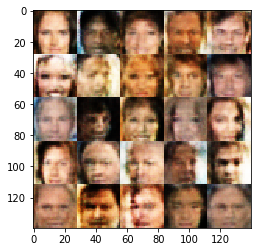

Epoch 1/1, iteration 2010: Discriminator Loss: 1.1712, Generator Loss: 0.9780
Epoch 1/1, iteration 2020: Discriminator Loss: 1.2621, Generator Loss: 0.8650
Epoch 1/1, iteration 2030: Discriminator Loss: 1.4313, Generator Loss: 0.8195
Epoch 1/1, iteration 2040: Discriminator Loss: 1.1798, Generator Loss: 0.8459
Epoch 1/1, iteration 2050: Discriminator Loss: 1.2229, Generator Loss: 0.8006
Epoch 1/1, iteration 2060: Discriminator Loss: 1.4972, Generator Loss: 0.6917
Epoch 1/1, iteration 2070: Discriminator Loss: 1.3618, Generator Loss: 0.7557
Epoch 1/1, iteration 2080: Discriminator Loss: 1.2042, Generator Loss: 1.0906
Epoch 1/1, iteration 2090: Discriminator Loss: 1.2692, Generator Loss: 0.8151
Epoch 1/1, iteration 2100: Discriminator Loss: 1.2562, Generator Loss: 0.8206


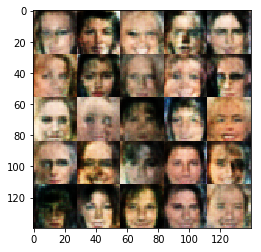

Epoch 1/1, iteration 2110: Discriminator Loss: 1.3891, Generator Loss: 0.6352
Epoch 1/1, iteration 2120: Discriminator Loss: 1.3226, Generator Loss: 0.9712
Epoch 1/1, iteration 2130: Discriminator Loss: 1.1497, Generator Loss: 1.0462
Epoch 1/1, iteration 2140: Discriminator Loss: 1.2382, Generator Loss: 0.9077
Epoch 1/1, iteration 2150: Discriminator Loss: 1.3993, Generator Loss: 0.7621
Epoch 1/1, iteration 2160: Discriminator Loss: 1.2779, Generator Loss: 0.9724
Epoch 1/1, iteration 2170: Discriminator Loss: 1.0746, Generator Loss: 1.1388
Epoch 1/1, iteration 2180: Discriminator Loss: 1.4722, Generator Loss: 0.7008
Epoch 1/1, iteration 2190: Discriminator Loss: 1.6959, Generator Loss: 0.5876
Epoch 1/1, iteration 2200: Discriminator Loss: 1.1748, Generator Loss: 0.9753


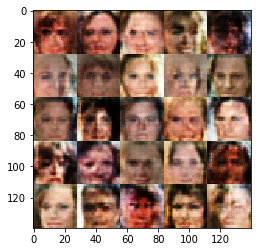

Epoch 1/1, iteration 2210: Discriminator Loss: 1.3052, Generator Loss: 0.7388
Epoch 1/1, iteration 2220: Discriminator Loss: 1.0835, Generator Loss: 0.9537
Epoch 1/1, iteration 2230: Discriminator Loss: 1.3475, Generator Loss: 0.8121
Epoch 1/1, iteration 2240: Discriminator Loss: 1.1793, Generator Loss: 0.8307
Epoch 1/1, iteration 2250: Discriminator Loss: 1.2080, Generator Loss: 0.9118
Epoch 1/1, iteration 2260: Discriminator Loss: 1.2701, Generator Loss: 0.7288
Epoch 1/1, iteration 2270: Discriminator Loss: 1.2840, Generator Loss: 0.8501
Epoch 1/1, iteration 2280: Discriminator Loss: 1.3430, Generator Loss: 0.9902
Epoch 1/1, iteration 2290: Discriminator Loss: 1.3313, Generator Loss: 0.9683
Epoch 1/1, iteration 2300: Discriminator Loss: 1.3122, Generator Loss: 0.9594


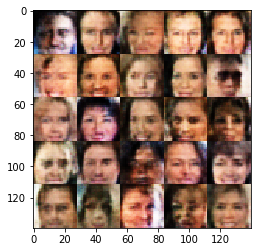

Epoch 1/1, iteration 2310: Discriminator Loss: 1.1714, Generator Loss: 0.9256
Epoch 1/1, iteration 2320: Discriminator Loss: 1.3085, Generator Loss: 0.9668
Epoch 1/1, iteration 2330: Discriminator Loss: 1.0957, Generator Loss: 1.0137
Epoch 1/1, iteration 2340: Discriminator Loss: 1.2177, Generator Loss: 0.8135
Epoch 1/1, iteration 2350: Discriminator Loss: 1.2055, Generator Loss: 0.9716
Epoch 1/1, iteration 2360: Discriminator Loss: 1.3134, Generator Loss: 0.7717
Epoch 1/1, iteration 2370: Discriminator Loss: 1.3153, Generator Loss: 0.8519
Epoch 1/1, iteration 2380: Discriminator Loss: 1.1720, Generator Loss: 0.9665
Epoch 1/1, iteration 2390: Discriminator Loss: 1.1291, Generator Loss: 1.0265
Epoch 1/1, iteration 2400: Discriminator Loss: 1.2946, Generator Loss: 0.7270


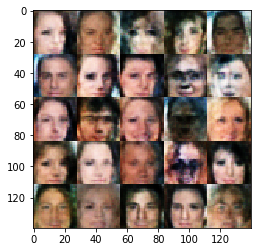

Epoch 1/1, iteration 2410: Discriminator Loss: 1.1324, Generator Loss: 1.0174
Epoch 1/1, iteration 2420: Discriminator Loss: 1.0060, Generator Loss: 1.4450
Epoch 1/1, iteration 2430: Discriminator Loss: 1.0924, Generator Loss: 0.9042
Epoch 1/1, iteration 2440: Discriminator Loss: 1.2490, Generator Loss: 0.8313
Epoch 1/1, iteration 2450: Discriminator Loss: 1.2008, Generator Loss: 0.7967
Epoch 1/1, iteration 2460: Discriminator Loss: 1.2555, Generator Loss: 0.6643
Epoch 1/1, iteration 2470: Discriminator Loss: 1.4355, Generator Loss: 0.6256
Epoch 1/1, iteration 2480: Discriminator Loss: 1.2795, Generator Loss: 0.8133
Epoch 1/1, iteration 2490: Discriminator Loss: 1.2575, Generator Loss: 0.7272
Epoch 1/1, iteration 2500: Discriminator Loss: 1.1266, Generator Loss: 1.1113


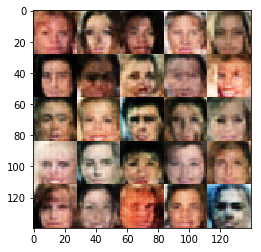

Epoch 1/1, iteration 2510: Discriminator Loss: 1.2611, Generator Loss: 0.8881
Epoch 1/1, iteration 2520: Discriminator Loss: 1.0864, Generator Loss: 1.3601
Epoch 1/1, iteration 2530: Discriminator Loss: 1.3553, Generator Loss: 0.6357
Epoch 1/1, iteration 2540: Discriminator Loss: 1.1923, Generator Loss: 0.7712
Epoch 1/1, iteration 2550: Discriminator Loss: 1.1435, Generator Loss: 1.0524
Epoch 1/1, iteration 2560: Discriminator Loss: 1.3949, Generator Loss: 0.8505
Epoch 1/1, iteration 2570: Discriminator Loss: 1.3181, Generator Loss: 0.9954
Epoch 1/1, iteration 2580: Discriminator Loss: 1.2529, Generator Loss: 0.6910
Epoch 1/1, iteration 2590: Discriminator Loss: 1.2214, Generator Loss: 0.9015
Epoch 1/1, iteration 2600: Discriminator Loss: 1.2541, Generator Loss: 0.8659


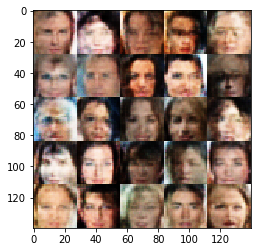

Epoch 1/1, iteration 2610: Discriminator Loss: 1.2339, Generator Loss: 0.8850
Epoch 1/1, iteration 2620: Discriminator Loss: 1.1405, Generator Loss: 0.9435
Epoch 1/1, iteration 2630: Discriminator Loss: 1.3124, Generator Loss: 0.7103
Epoch 1/1, iteration 2640: Discriminator Loss: 1.3408, Generator Loss: 0.7710
Epoch 1/1, iteration 2650: Discriminator Loss: 1.1896, Generator Loss: 0.9679
Epoch 1/1, iteration 2660: Discriminator Loss: 1.2484, Generator Loss: 0.8943
Epoch 1/1, iteration 2670: Discriminator Loss: 1.2779, Generator Loss: 0.7495
Epoch 1/1, iteration 2680: Discriminator Loss: 1.3260, Generator Loss: 0.7592
Epoch 1/1, iteration 2690: Discriminator Loss: 1.2233, Generator Loss: 0.8808
Epoch 1/1, iteration 2700: Discriminator Loss: 1.2417, Generator Loss: 0.7164


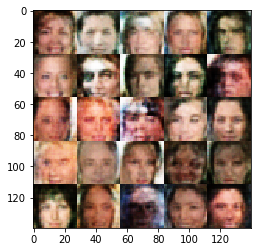

Epoch 1/1, iteration 2710: Discriminator Loss: 1.1511, Generator Loss: 1.0603
Epoch 1/1, iteration 2720: Discriminator Loss: 1.2407, Generator Loss: 0.9854
Epoch 1/1, iteration 2730: Discriminator Loss: 1.5267, Generator Loss: 0.6940
Epoch 1/1, iteration 2740: Discriminator Loss: 1.2152, Generator Loss: 1.0221
Epoch 1/1, iteration 2750: Discriminator Loss: 1.3390, Generator Loss: 0.8529
Epoch 1/1, iteration 2760: Discriminator Loss: 1.3714, Generator Loss: 0.7502
Epoch 1/1, iteration 2770: Discriminator Loss: 1.3804, Generator Loss: 0.9053
Epoch 1/1, iteration 2780: Discriminator Loss: 1.1975, Generator Loss: 0.7994
Epoch 1/1, iteration 2790: Discriminator Loss: 1.3684, Generator Loss: 0.9318
Epoch 1/1, iteration 2800: Discriminator Loss: 1.3263, Generator Loss: 0.7821


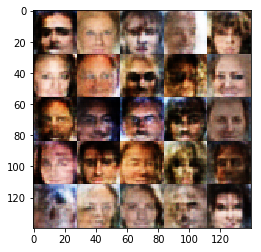

Epoch 1/1, iteration 2810: Discriminator Loss: 1.2372, Generator Loss: 0.8257
Epoch 1/1, iteration 2820: Discriminator Loss: 1.2592, Generator Loss: 0.7572
Epoch 1/1, iteration 2830: Discriminator Loss: 1.2591, Generator Loss: 0.7743
Epoch 1/1, iteration 2840: Discriminator Loss: 1.1662, Generator Loss: 0.8555
Epoch 1/1, iteration 2850: Discriminator Loss: 1.2395, Generator Loss: 0.8737
Epoch 1/1, iteration 2860: Discriminator Loss: 1.2754, Generator Loss: 0.9196
Epoch 1/1, iteration 2870: Discriminator Loss: 1.1596, Generator Loss: 1.0800
Epoch 1/1, iteration 2880: Discriminator Loss: 1.0394, Generator Loss: 1.1383
Epoch 1/1, iteration 2890: Discriminator Loss: 0.8495, Generator Loss: 1.4001
Epoch 1/1, iteration 2900: Discriminator Loss: 1.1939, Generator Loss: 0.9473


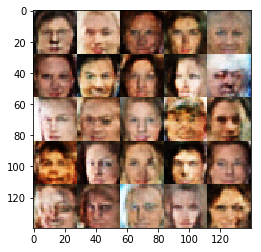

Epoch 1/1, iteration 2910: Discriminator Loss: 1.2660, Generator Loss: 0.9419
Epoch 1/1, iteration 2920: Discriminator Loss: 1.1164, Generator Loss: 1.0140
Epoch 1/1, iteration 2930: Discriminator Loss: 1.1824, Generator Loss: 0.9080
Epoch 1/1, iteration 2940: Discriminator Loss: 1.1126, Generator Loss: 0.8972
Epoch 1/1, iteration 2950: Discriminator Loss: 1.2648, Generator Loss: 1.0417
Epoch 1/1, iteration 2960: Discriminator Loss: 1.1104, Generator Loss: 1.0462
Epoch 1/1, iteration 2970: Discriminator Loss: 1.1444, Generator Loss: 0.9219
Epoch 1/1, iteration 2980: Discriminator Loss: 1.2169, Generator Loss: 0.7999
Epoch 1/1, iteration 2990: Discriminator Loss: 1.1930, Generator Loss: 0.9690
Epoch 1/1, iteration 3000: Discriminator Loss: 1.3401, Generator Loss: 0.8385


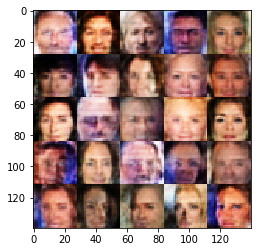

Epoch 1/1, iteration 3010: Discriminator Loss: 1.2041, Generator Loss: 0.9374
Epoch 1/1, iteration 3020: Discriminator Loss: 1.2056, Generator Loss: 0.8752
Epoch 1/1, iteration 3030: Discriminator Loss: 1.2238, Generator Loss: 0.7993
Epoch 1/1, iteration 3040: Discriminator Loss: 1.3391, Generator Loss: 0.7866
Epoch 1/1, iteration 3050: Discriminator Loss: 1.3617, Generator Loss: 0.8336
Epoch 1/1, iteration 3060: Discriminator Loss: 1.3646, Generator Loss: 0.8381
Epoch 1/1, iteration 3070: Discriminator Loss: 1.3545, Generator Loss: 1.3492
Epoch 1/1, iteration 3080: Discriminator Loss: 1.1165, Generator Loss: 0.9867
Epoch 1/1, iteration 3090: Discriminator Loss: 1.3457, Generator Loss: 0.7763
Epoch 1/1, iteration 3100: Discriminator Loss: 1.2143, Generator Loss: 0.9462


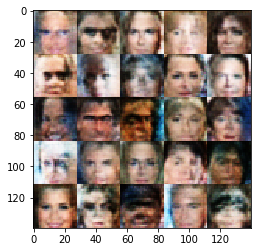

Epoch 1/1, iteration 3110: Discriminator Loss: 1.1591, Generator Loss: 0.9929
Epoch 1/1, iteration 3120: Discriminator Loss: 1.0430, Generator Loss: 1.1139
Epoch 1/1, iteration 3130: Discriminator Loss: 1.0765, Generator Loss: 0.8822
Epoch 1/1, iteration 3140: Discriminator Loss: 1.2073, Generator Loss: 0.7748
Epoch 1/1, iteration 3150: Discriminator Loss: 1.2713, Generator Loss: 0.8271
Epoch 1/1, iteration 3160: Discriminator Loss: 1.3252, Generator Loss: 0.9272


ValueError: Parent directory of ./checkpoints/generator.ckpt doesn't exist, can't save.

In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.